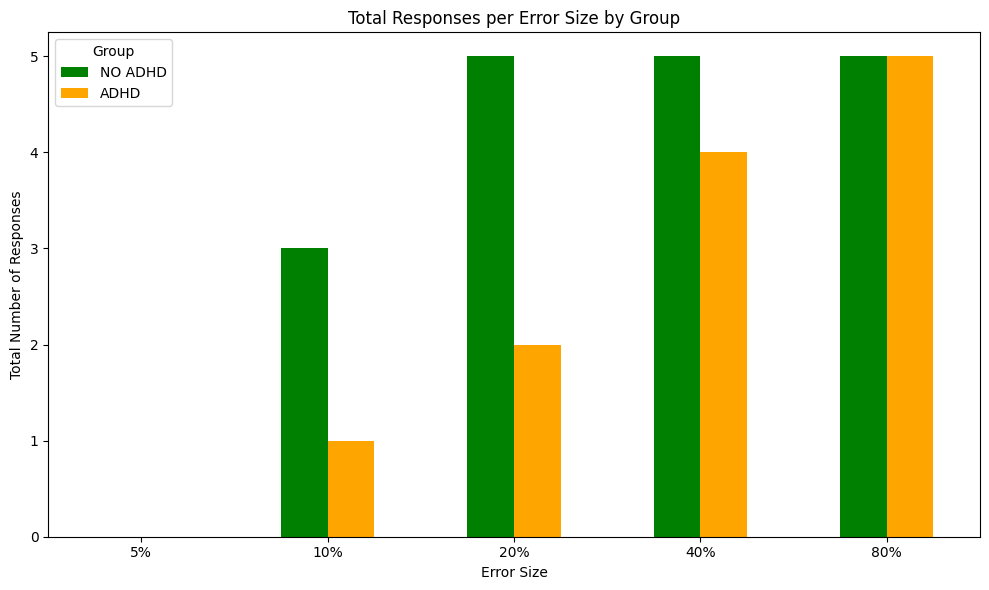

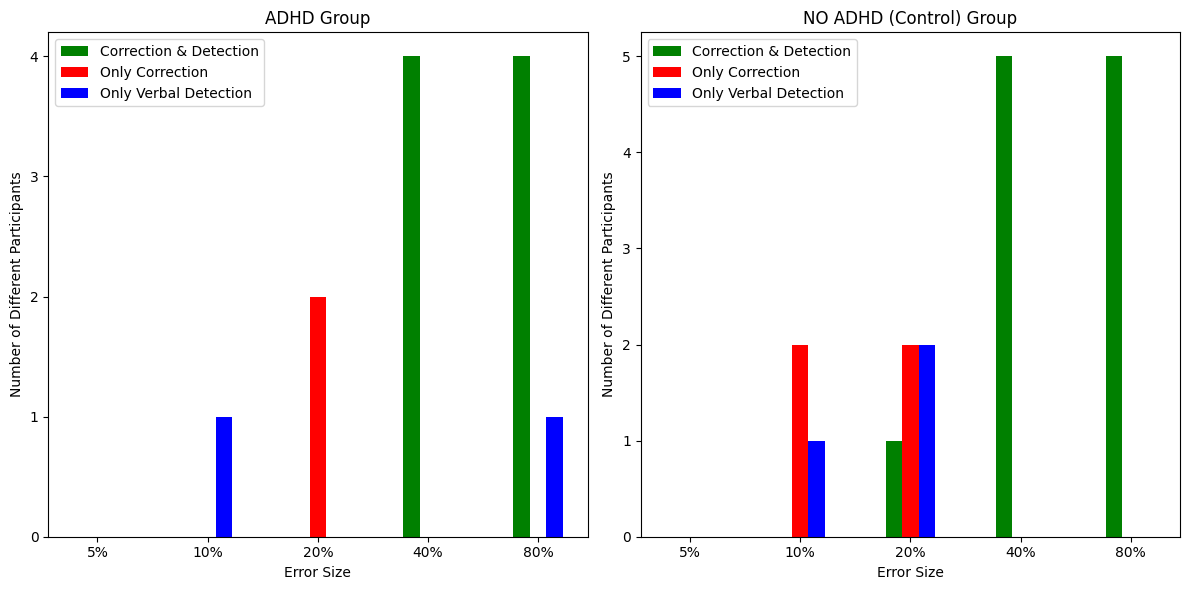

In [17]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Load data
data = pd.read_excel('/content/InsightsLog.xlsx')

# Convert boolean columns to integers for easier aggregation
data['Correction'] = data['Correction'].astype(float)
data['Verbal_Detection'] = data['Verbal_Detection'].astype(float)

# Summing both corrections and verbal detections into a single value per group per error size
data['Total_Responses'] = np.ceil((data['Correction'] + data['Verbal_Detection']) / 2)

# Group data by ADHD status and Error_Size, then sum total error responses
grouped_data = data.groupby(['ADHD', 'Error_Size']).agg({'Total_Responses': 'sum'}).unstack(level=0)
grouped_data.columns = grouped_data.columns.droplevel(0)  # Remove multi-level column

colors = ['green', 'orange']  # One color for each group
labels = ['NO ADHD', 'ADHD']  # Labels for the legend
error_size_labels = [f"{label}%" for label in grouped_data.index.get_level_values(0)]  # Extracting error sizes and appending '%'

fig, ax = plt.subplots(figsize=(10, 6))
grouped_data.plot(kind='bar', color=colors, ax=ax)
plt.title('Total Responses per Error Size by Group')
plt.xlabel('Error Size')
plt.ylabel('Total Number of Responses')
ax.legend(labels, title='Group')
ax.set_xticklabels(error_size_labels, rotation=0)  # Setting labels with rotation
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))  # Ensure y-axis ticks are integers
plt.tight_layout()

# Creating necessary flags in the data
data['Corr_True_Verb_True'] = ((data['Correction'] == True) & (data['Verbal_Detection'] == True))
data['Corr_True_Verb_False'] = ((data['Correction'] == True) & (data['Verbal_Detection'] == False))
data['Corr_False_Verb_True'] = ((data['Correction'] == False) & (data['Verbal_Detection'] == True))

# Grouping data by 'ADHD', 'Error_Size' and aggregating by sum to count True instances
grouped = data.groupby(['ADHD', 'Error_Size']).agg({
    'Corr_True_Verb_True': 'sum',
    'Corr_True_Verb_False': 'sum',
    'Corr_False_Verb_True': 'sum'
}).reset_index()

# Filtering the error sizes
error_sizes = [5, 10, 20, 40, 80]
grouped = grouped[grouped['Error_Size'].isin(error_sizes)]

# Ensuring all specified error sizes are present in the DataFrame
complete_index = pd.MultiIndex.from_product([grouped['ADHD'].unique(), error_sizes], names=['ADHD', 'Error_Size'])
grouped.set_index(['ADHD', 'Error_Size'], inplace=True)
grouped = grouped.reindex(complete_index, fill_value=0).reset_index()

# Splitting data for ADHD and NO ADHD
adhd_data = grouped[grouped['ADHD'] == True]
no_adhd_data = grouped[grouped['ADHD'] == False]

def plot_group_data(df, title, ax):
    bar_width = 0.15  # Adjusted for better spacing
    x = range(len(df['Error_Size']))  # Adjust x positions for each bar group
    ax.bar([p - bar_width for p in x], df['Corr_True_Verb_True'], width=bar_width, color='green', label='Correction & Detection')
    ax.bar(x, df['Corr_True_Verb_False'], width=bar_width, color='red', label='Only Correction')
    ax.bar([p + bar_width for p in x], df['Corr_False_Verb_True'], width=bar_width, color='blue', label='Only Verbal Detection')
    ax.set_title(title)
    ax.set_xlabel('Error Size')
    ax.set_ylabel('Number of Different Participants')
    ax.set_xticks(x)
    ax.set_xticklabels(df['Error_Size'].astype(str) + '%')
    ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    ax.legend()


fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Adjusted figure size for better spacing
plot_group_data(adhd_data, 'ADHD Group', axs[0])
plot_group_data(no_adhd_data, 'NO ADHD (Control) Group', axs[1])
plt.tight_layout()

# Show all plots
plt.show()
